In [3]:
from source import Dataset
from source import tools
import awkward as ak
import glob
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-12-04 15:24:12.498484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 15:24:12.766626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-04 15:24:12.766660: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-04 15:24:14.221750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
#selecting features 
branches_to_train = [
"cscRechitClusterX",
"cscRechitClusterY",
"cscRechitClusterZ",
"cscRechitClusterTimeWeighted",
"cscRechitClusterTimeSpreadWeightedAll",
"cscRechitClusternXY",
"cscRechitClusternZ",
"cscRechitClusterXSpread",
"cscRechitClusterYSpread",
"cscRechitClusterZSpread",
"cscRechitClusterXYSpread",
"cscRechitClusterRSpread",
"cscRechitClusterEtaPhiSpread",
"cscRechitClusterEtaSpread",
"cscRechitClusterPhiSpread",
"cscRechitClusterDeltaRSpread",
"cscRechitClusterMajorAxis",
"cscRechitClusterMinorAxis",
"cscRechitClusterSkewX",
"cscRechitClusterSkewY",
"cscRechitClusterSkewZ",
"cscRechitClusterKurtX",
"cscRechitClusterKurtY",
"cscRechitClusterKurtZ",
"cscRechitClusterSize",
]

#padded_branches_to_train = []
#for col in branches_to_train:           
#    #creates padded column for each jet of each "Jets/Jets." key
#    for icol in range(10):
#        new_col_name = col+"_"+str(icol)
#        padded_branches_to_train.append(new_col_name)

#branches_to_train = [
#    "cscRechitClusterSize",
#]

print(branches_to_train)
truth_value = "cscRechitCluster_match_gLLP_e"


['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterTimeWeighted', 'cscRechitClusterTimeSpreadWeightedAll', 'cscRechitClusternXY', 'cscRechitClusternZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterXYSpread', 'cscRechitClusterRSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterDeltaRSpread', 'cscRechitClusterMajorAxis', 'cscRechitClusterMinorAxis', 'cscRechitClusterSkewX', 'cscRechitClusterSkewY', 'cscRechitClusterSkewZ', 'cscRechitClusterKurtX', 'cscRechitClusterKurtY', 'cscRechitClusterKurtZ', 'cscRechitClusterSize']


In [5]:
#dataset_signal = Dataset.Dataset("signal")
#loaded_array_signal = dataset_signal.load("/nfs/dust/cms/user/lbenato/ML_LLP/MDS_regression/datasets/test_v6.h5")

In [6]:
dataset_signal = Dataset.Dataset("signal")
df_signal = dataset_signal.load_df("/nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_df_v6.h5")

Opening file  /nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_df_v6.h5


In [7]:
df_signal.shape

(90016, 79)

In [8]:
#Consider only data with proper gen matching
df_signal = df_signal[ df_signal["cscRechitCluster_match_gLLP"]>=1 ]

In [9]:
df_signal.shape

(79780, 79)

In [10]:
print(df_signal)

          weight  evtNum  cscRechitCluster_match_gLLP  \
entry                                                   
0      23.164499  502880                         True   
1      23.164499  502904                         True   
2      23.164499  502907                         True   
3      23.164499  502907                         True   
4      23.164499  502929                         True   
...          ...     ...                          ...   
90008  23.164499  552795                         True   
90009  23.164499  552829                         True   
90011  23.164499  552858                         True   
90012  23.164499  552905                         True   
90014  23.164499  552967                         True   

       cscRechitCluster_match_gLLP_minDeltaR  \
entry                                          
0                                   0.021920   
1                                   0.019714   
2                                   0.076979   
3                 

In [11]:
#splitting the data into train, test and validation
#from sklearn.model_selection import train_test_split
#
#loaded_array_signal_64 = dataset_signal.get_unstructured_numpy(loaded_array_signal)
#print(loaded_array_signal.dtype)
#print(loaded_array_signal_64.dtype)
#    
#loaded_array_signal_df = loaded_array_signal_64
#
#print(loaded_array_signal_64)

In [12]:
# Splitting the loaded_array_signal data
#train_data, testval_data = train_test_split(loaded_array_signal_df, train_size=0.6)
train_data, testval_data = train_test_split(df_signal, train_size=0.6)
test_data, val_data = train_test_split(testval_data, test_size=0.5)

# assigning labels
train_labels = np.array(train_data[truth_value])#([1.]*len(train_data))
test_labels = np.array(test_data[truth_value])#([1.]*len(test_data))
val_labels = np.array(val_data[truth_value])#([1.]*len(val_data))

train_data = train_data[branches_to_train]
test_data = test_data[branches_to_train]
val_data = val_data[branches_to_train]

# check the shape
print("First example:")
print("signal training features", train_data.shape)
print("signal training labels", train_labels.shape)
print("signal test features", test_data.shape)
print("signal test labels", test_labels.shape)
print("signal val features", val_data.shape)
print("signal val labels", val_labels.shape)

print(train_labels)
print(train_data[branches_to_train])

#print(type(train_data), type(train_labels))
n_features = train_data.shape[1]

First example:
signal training features (47868, 25)
signal training labels (47868,)
signal test features (15956, 25)
signal test labels (15956,)
signal val features (15956, 25)
signal val labels (15956,)
[108.45256805  64.96260071 190.56190491 ... 104.01509857 112.09381866
 196.21965027]
       cscRechitClusterX  cscRechitClusterY  cscRechitClusterZ  \
entry                                                            
1081         -589.669617         -14.883728         830.549927   
21587          96.030716        -158.929947         613.435364   
6476          -49.646149        -390.059998         945.089417   
73995         174.169342         124.088585         798.918335   
42382         101.735916         104.503784         643.567566   
...                  ...                ...                ...   
11571         347.790222         396.471985        -735.170105   
10220        -174.802307        -331.374969         721.886292   
44639         573.748657        -143.371353        

In [13]:
n_features

25

In [12]:
# concatenate data
#train_data = np.concatenate([bkg_train_data,sig_train_data], axis=0)
#test_data = np.concatenate([bkg_test_data, sig_test_data], axis=0)
#val_data = np.concatenate([bkg_val_data, sig_val_data], axis=0)

#train_labels = np.concatenate([bkg_train_labels, sig_train_labels], axis=0)
#test_labels = np.concatenate([bkg_test_labels, sig_test_labels], axis=0)
#val_labels = np.concatenate([bkg_val_labels, sig_val_labels], axis=0)

print("training features", train_data.shape)
print("training labels", train_labels.shape)
print("test features", test_data.shape)
print("test labels", test_labels.shape)
print("val features", val_data.shape)
print("val labels", val_labels.shape)
print(val_labels)

training features (47868, 25)
training labels (47868,)
test features (15956, 25)
test labels (15956,)
val features (15956, 25)
val labels (15956,)
[101.84392548  55.56621552 150.77801514 ... 249.88980103  98.42115021
 175.31388855]


In [13]:
 # shuffle

X_train, Y_train = sklearn.utils.shuffle(train_data, train_labels, random_state=0) # change to random_state=None for full randomness
X_test, Y_test = sklearn.utils.shuffle(test_data, test_labels, random_state=0) # change to random_state=None for full randomness
X_val, Y_val = sklearn.utils.shuffle(val_data, val_labels, random_state=0) # change to random_state=None for full randomness

print("shuffled training features", X_train)
print("shuffled training features", X_train.shape)
print("shuffled training labels", Y_train)
print("shuffled training labels", Y_train.shape)

shuffled training features        cscRechitClusterX  cscRechitClusterY  cscRechitClusterZ  \
entry                                                            
74465        -403.417755         151.530716         716.426758   
2990         -463.151428         289.679993         696.388489   
43889        -324.162872          38.468750         993.104675   
52600         389.347382         330.284302         955.644165   
47567        -458.647888         -35.449791        1024.200562   
...                  ...                ...                ...   
11092         180.855728         449.092865        -844.378723   
27921         237.999893         541.835571        1027.039429   
48613         500.858856         334.032867        1037.483154   
24953         254.236343          61.057384        -831.534058   
15354         314.023041         286.612610         711.015320   

       cscRechitClusterTimeWeighted  cscRechitClusterTimeSpreadWeightedAll  \
entry                               

In [14]:
#defining the model and metrics
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    #initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=200, seed=None)
    initializer = tf.keras.initializers.Constant(value=100)

    
    model = keras.Sequential([
        #keras.layers.Dense(5, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        #keras.layers.Dropout(0.5),
        #keras.layers.Dense(1, activation='relu', bias_initializer=output_bias, kernel_initializer=initializer)
        #Attempt:
        keras.layers.Dense(50, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(5, activation='relu'),
        #keras.layers.Dense(1, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        keras.layers.Dense(1)

    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        #optimizer=keras.optimizers.SGD(learning_rate=0.01),
        #loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.MeanSquaredError(name='MSE'),
        metrics=metrics
    )
    
    return model

# TODO: Find best way to init weights

In [15]:
EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #val_prec
    verbose=1,
    patience=10,
    mode='min',#max
    restore_best_weights=True)

In [16]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1300      
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 5)                 105       
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________


In [17]:
output = model.predict(X_train)
print(output)
print(Y_train)

1496/1496 [==============================] - 1s 532us/step
[[40075.76 ]
 [49003.887]
 [37485.74 ]
 ...
 [71490.32 ]
 [86451.414]
 [67038.86 ]]
[103.19415283 111.37741852 170.25746155 ... 125.39369202 180.44848633
 218.00059509]


In [18]:
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 4002170624.0000


In [19]:
model = make_model()
history = model.fit(
    X_train,
    Y_train,
    batch_size=100,
    epochs=EPOCHS, #EPOCHS
    callbacks=[early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
479/479 [==============================] - 3s 3ms/step - loss: 2740824064.0000 - cross entropy: -1178.0653 - Brier score: 3371495168.0000 - tp: 70929.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 24807.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.7409 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 16092.4375 - val_cross entropy: -1474.0087 - val_Brier score: 16092.4375 - val_tp: 12798.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 3158.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.8021 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 2/100
479/479 [==============================] - 1s 2ms/step - loss: 16973.7363 - cross entropy: -1792.1111 - Brier score: 16973.7363 - tp: 41000.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 6868.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.8565 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 15996.0293 - val_cross entropy: -1958.6625 - val_Brier score: 15996.0293 - val_tp: 15937.0000 - val

479/479 [==============================] - 1s 2ms/step - loss: 13729.3535 - cross entropy: -2262.7529 - Brier score: 13729.3535 - tp: 46740.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1128.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.9764 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 11842.4492 - val_cross entropy: -2374.3479 - val_Brier score: 11842.4492 - val_tp: 15956.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 30/100
479/479 [==============================] - 1s 2ms/step - loss: 14077.5176 - cross entropy: -2270.1467 - Brier score: 14077.5176 - tp: 46801.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1067.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.9777 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 11381.5527 - val_cross entropy: -2374.3479 - val_Brier score: 11381.5527 - val_tp: 15956.0000 - val_fp: 0.0000e+00 - val

In [20]:
pred_output = model.predict(X_train[:10])
print(pred_output)
print(Y_train[:10])

results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss on training: {:0.4f}".format(results[0]))

results_val = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE, verbose=0)
print("Loss on validation: {:0.4f}".format(results_val[0]))

1/1 [==============================] - 0s 63ms/step
[[108.90208 ]
 [129.56253 ]
 [105.229164]
 [143.33902 ]
 [107.57322 ]
 [ 73.95606 ]
 [117.88712 ]
 [115.19962 ]
 [168.92227 ]
 [153.2261  ]]
[103.19415283 111.37741852 170.25746155 126.65801239 131.60432434
 136.67912292 147.08555603 131.7905426   76.76410675 121.31212616]
Loss on training: 8520.8105
Loss on validation: 8459.2793


In [21]:
# Plots of loss vs epoch 
# Plot of ROC

train_predictions = model.predict(train_data, batch_size=BATCH_SIZE)
test_predictions = model.predict(test_data, batch_size=BATCH_SIZE)
print(len(test_data),len(test_predictions))

16/16 [==============================] - 0s 1ms/step
15956 15956


In [22]:
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history.keys())

[2740824064.0, 16973.736328125, 16001.33203125, 16271.1630859375, 15716.0751953125, 15422.974609375, 15047.6982421875, 14623.7548828125, 14310.71875, 14008.3349609375, 13755.5625, 16326.5595703125, 12819.048828125, 24250.015625, 11654.2626953125, 11706.8154296875, 11698.7744140625, 11747.029296875, 11720.2373046875, 11710.576171875, 11901.197265625, 11866.396484375, 12442.208984375, 12431.2001953125, 12462.779296875, 12545.6123046875, 12707.1044921875, 12832.0859375, 13729.353515625, 14077.517578125, 12116.560546875, 14346.6494140625, 13910.701171875, 13337.6005859375, 12064.93359375, 11190.916015625, 15169.0263671875, 12286.9599609375, 10700.720703125, 12085.1513671875, 12276.890625, 9994.4169921875, 10513.0380859375, 9742.9326171875, 10607.6787109375, 9817.212890625, 13860.4658203125, 10406.15625, 10289.01171875, 10517.1171875, 10051.322265625, 9907.1103515625, 9875.404296875, 9530.6923828125, 9419.658203125]
[16092.4375, 15996.029296875, 16066.64453125, 15969.990234375, 15546.478515

In [23]:
#AUC
#sklearn.metrics.roc_auc_score(test_labels, test_predictions_baseline)

In [24]:
#sklearn.metrics.roc_auc_score(train_labels, train_predictions_baseline)

In [25]:
from source.tools import tools
obj = tools()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    metrics = ['loss', 'Brier score', 'precision', 'recall']
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([1, plt.ylim()[1]])
            plt.yscale("log")
        elif metric == 'auc':
            plt.ylim([0.8,1])
        elif metric == 'Brier score':
            plt.ylim([0.1,12527118336])
            plt.yscale("log")
        else:
            plt.ylim([0,1.1])

        plt.legend()

[3371495168.0, 16973.736328125, 16001.33203125, 16271.1630859375, 15716.0751953125, 15422.974609375, 15047.6982421875, 14623.75390625, 14310.71875, 14008.3349609375, 13755.5625, 16326.5595703125, 12819.048828125, 24250.017578125, 11654.2626953125, 11706.8154296875, 11698.7744140625, 11747.029296875, 11720.2373046875, 11710.576171875, 11901.197265625, 11866.396484375, 12442.208984375, 12431.2001953125, 12462.779296875, 12545.6123046875, 12707.1044921875, 12832.0859375, 13729.353515625, 14077.517578125, 12116.560546875, 14346.6494140625, 13910.701171875, 13337.6005859375, 12064.93359375, 11190.916015625, 15169.0263671875, 12286.9599609375, 10700.720703125, 12085.1513671875, 12276.890625, 9994.4169921875, 10513.0380859375, 9742.9326171875, 10607.6796875, 9817.212890625, 13860.4658203125, 10406.15625, 10289.01171875, 10517.1171875, 10051.322265625, 9907.1103515625, 9875.404296875, 9530.6923828125, 9419.658203125]


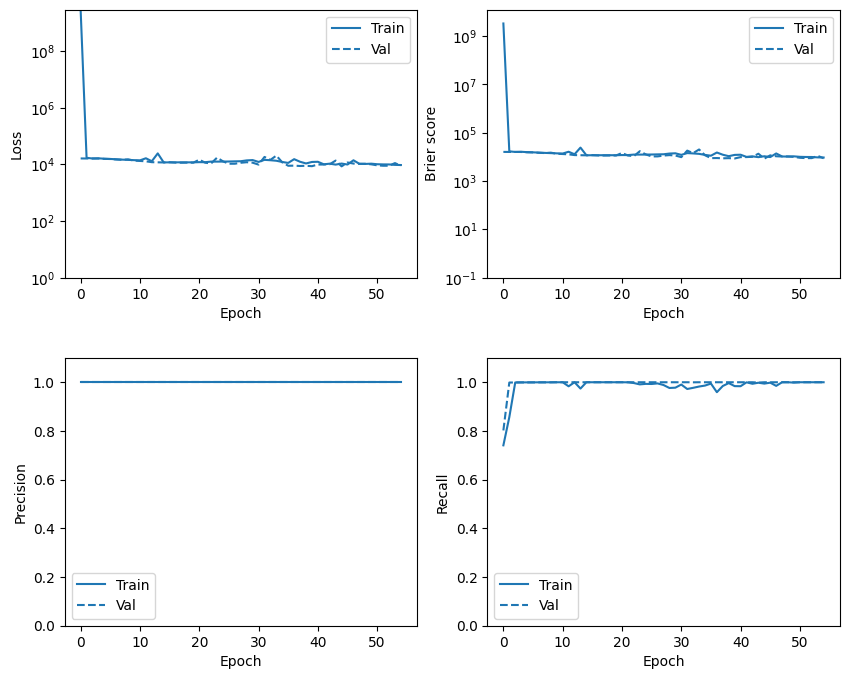

In [26]:
plot_metrics(history)
print(history.history['Brier score'])

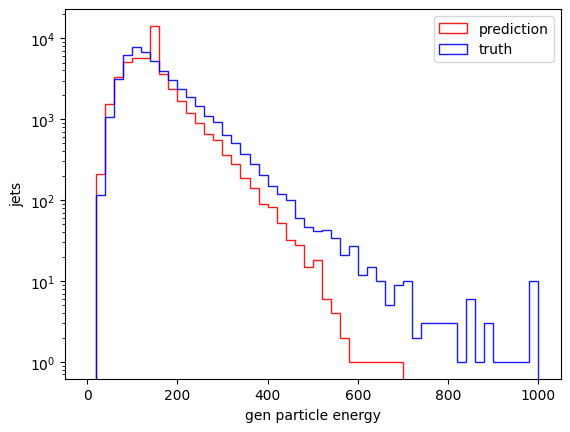

[[148.11008 ]
 [ 76.15299 ]
 [ 75.62324 ]
 ...
 [147.74258 ]
 [ 63.285347]
 [118.75266 ]]


In [27]:
obj = tools()
obj.plotHist(train_predictions,train_labels, bins = 50, interval=[0,1000] ,logy=True, logx=False, labels=["prediction","truth"],
             xlabel= 'gen particle energy', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)

#obj.plotHist(test_predictions_signal, test_predictions_background, bins = 50, interval=[0,1], logy=True, logx=False, labels=["signal test", "background test"],
#             xlabel= 'DNN output', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)

print(train_predictions)

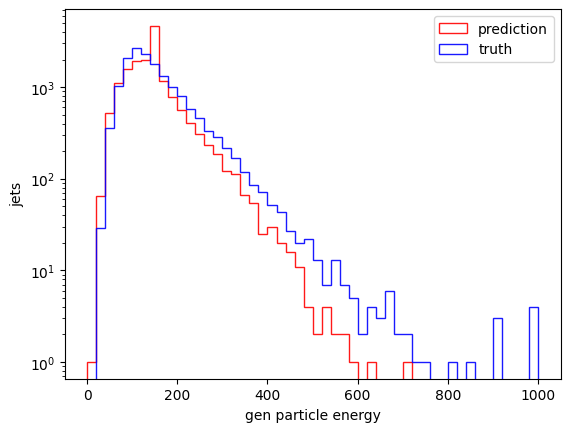

In [28]:
obj = tools()
obj.plotHist(test_predictions,test_labels, bins = 50, interval=[0,1000] ,logy=True, logx=False, labels=["prediction","truth"],
             xlabel= 'gen particle energy', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)